<a href="https://colab.research.google.com/github/nsimm22/Qlue/blob/master/SpaceRydeSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [68]:
#constants
Ft = 10000 #Thrust Force [N]
Mp = 10 #Payload Mass [kg]
Me = 15 #Engine Mass [kg]
rhoA = 2.70e3 #Density of 6061 T6 Al [kg/m^3]
rhoAir = 1.225
uts = 290e6 #ultimate tensile strength of 6061 T6 Al [Pa]
tb = 0.002 #thickness of body [m]
Ptank = 2.5e6 #tank operating pressure [Pa]
Isp = 250 #specific impulse [s]
g = 9.81 #accel due to gravity [m/s^2]
t = 100
rhoOx = 1140 #Density of Oxidizer [kg/m^3]
rhoKer = 820.1 #Density of Kerosene [kg/m^3]
Cd = 0.75 #estimated coefficient of drag

In [69]:
#Fuel Calcs
mdot_tot = Ft/(Isp*g) #mass flow rate in kg/s

#ASSUMING Fuel ratio was a mass ratio
mdot_Ox = mdot_tot * (2.5/3.5)#mass flow rate of Oxidizer [kg/s]
mdot_Ker = mdot_tot * (1/3.5) #mass flow rate of kerosene [kg/s]
m_Ox = mdot_Ox * t 
m_Ker = mdot_Ker * t
vol_Ox = m_Ox/rhoOx
vol_Ker = m_Ker/rhoKer
vol_tot = vol_Ker + vol_Ox
print("Total Volume Req [m^3]: " + str(vol_tot))

Total Volume Req [m^3]: 0.39753556993125294


In [70]:
#Calculates Force of Drag based on the coefficient of drag, density, velocity and cross-sectional area
def Fdrag(rho, v, Ac):
  return (0.5*rho*Ac*Cd*(v**2)) #N

#Calculates Force of Gravity based on total mass and gravity
def Fgrav(m, g):
  return (m*g)

#calculates the mass of a hollow cylinder - used for the body
def Mbody(r, h):
  cyl = np.pi*2*r*tb*h*rhoA
  tip = ((np.pi*h*r**2)/3) - ((np.pi*(h-tb)*(r-tb)**2)/3)
  return (cyl + tip)

def tank_specs(r, h):
  tank_thickness = (r*Ptank)/(2*uts*np.sqrt(3))
  max_vol = h*0.50*np.pi*r**2
  height = 0.50*h
  SA = (2*np.pi*r**2) + (2*np.pi*r)*height
  mass = SA*tank_thickness
  return(max_vol, mass, tank_thickness)



In [71]:
def rocket_launch(r, h, fuel_percent, t):
  
  t = t
  time = np.linspace(0,t,int(t*100))

  V = np.zeros(len(time))
  a = np.zeros(len(time))
  p = np.zeros(len(time))
  Fnet = np.zeros(len(time))
  Fg = np.zeros(len(time))
  Fd = np.zeros(len(time))
  Mi = np.zeros(len(time))
  v = np.zeros(len(time))

  #Set constants for each test
  Mb = Mbody(r, h) 
  Ac = np.pi*r**2
  max_vol, Mtank, tank_thickness = tank_specs(r, h)
  mCur_Ox = max_vol*fuel_percent * (2.22e-3)/(1.22e-3 + 2.22e-3) * rhoOx
  mCur_Ker = max_vol*fuel_percent * (1.22e-3)/(1.22e-3 + 2.22e-3) * rhoKer
  #set initial mass and gravitational force
  Mi[0] = Mtank + Me + Mp + Mb + mCur_Ox + mCur_Ker
  Fg[0] = Mi[0]*9.81 
  #set thrust to 10,000N
  Ft = 10000

  #check that thrust is 3 x the weight
  if(Mi[0]*g > 10000/3):
    index = 0
    return (p, v, a, Fnet, Fg, Fd, Mi, index)
    
  for i in range(len(time)-1):
    #Mass Updates
    if(mCur_Ox < 0 or mCur_Ker < 0):
      Ft = 0
      mCur_Ox = 0
      mCur_Ker = 0
    else:
      mCur_Ox = mCur_Ox - mdot_Ox*(time[1] - time[0])
      mCur_Ker = mCur_Ker - mdot_Ker*(time[1] - time[0])
    Mi[i] = Mtank + Me + Mp + Mb + mCur_Ox + mCur_Ker 
    #Force Updates
    Fg[i] = Fgrav(Mi[i], 9.81)
    Fd[i] = Fdrag(rhoAir, v[i], Ac)
    Fnet[i] = Ft - Fg[i] - Fd[i]
    #Kinematics
    a[i+1] = Fnet[i]/Mi[i]
    v[i + 1] = v[i] + a[i+1]*(time[1] - time[0])
    p[i + 1] = p[i] + v[i+1]*(time[1] - time[0])
    if(v[i+1] < 0):
      index = i
      break;
  index = i
  return (p, v, a, Fnet, Fg, Fd, Mi, index)

In [72]:
from scipy.optimize import fmin_cobyla

def objective(X):
    '''objective function to minimize. It is the negative of profit,
    which we seek to maximize.'''
    r, h, fuel_percent,t = X
    p, v, a, Fnet, Fg, Fd, Mi, i = rocket_launch(r, h, fuel_percent, t)
    return -(max(v))

def c1(X):
    #ensure L/D ratio > 4
    r, h, fuel_percent, t = X
    return -4 + (h)/(r*2)

def c2(X):
    #ensure fuel percent is < 1.0
    r, h, fuel_percent, t = X
    return 1.0 - fuel_percent

def c3(X):
    #ensure max weight is less then 3,333
    r, h, fuel_percent, t = X
    max_vol, Mtank, tank_thickness = tank_specs(r, h)
    Mb = Mbody(r, h)
    mCur_Ox = max_vol*fuel_percent * (2.22e-3)/(1.22e-3 + 2.22e-3) * rhoOx
    mCur_Ker = max_vol*fuel_percent * (1.22e-3)/(1.22e-3 + 2.22e-3) * rhoKer
    M = Mtank + Me + Mp + Mb + mCur_Ox + mCur_Ker
    return (10000/3) - (M*g)

def c4(X):
    #ensure L/D ratio < 25
    r, h, fuel_percent, t = X
    return 25 - (h)/(r*2)

def c5(X):
    r, h, fuel_percent,t = X
    return -10 + t

def c6(X):
    #ensure L/D ratio > 4
    r, h, fuel_percent, t = X
    return r
def c7(X):
    #ensure L/D ratio > 4
    r, h, fuel_percent, t = X
    return h

Optimization of Max Velocity


In [73]:
max_specs = [0,0,0,0]
maximum = 0

for i in range(10, 100, 4):
  print("checking " + str(i))
  X = fmin_cobyla(objective, x0=[0.2 + 0.001*i, 2.0+0.01*i, 0.5, i], cons=[c1, c2, c3, c4, c5, c6, c7])
  if(-objective(X) > maximum):
    max_specs = X
    maximum = -objective(X)

checking 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in double_scalars


checking 14
checking 18
checking 22
checking 26
checking 30
checking 34
checking 38
checking 42
checking 46
checking 50
checking 54
checking 58
checking 62
checking 66
checking 70
checking 74
checking 78
checking 82
checking 86
checking 90
checking 94
checking 98


In [74]:
p, v, a, Fnet, Fg, Fd, Mi, i = rocket_launch(max_specs[0], max_specs[1], max_specs[2], max_specs[3])
vels = list(v)
max_value = max(vels)
max_index = vels.index(max_value)
print('Radius of {0:1.2f} m.'.format(max_specs[0]))
print('Rocket height of {0:1.2f} m'.format(max_specs[1]))
print('Fuel Tank Percent {0:1.2f}% '.format(max_specs[2]*100))
print('Burn Time:  {0:4f} s '.format(max_index / 100))
print('Max Height:  {0:1.2f} m '.format(p[i]))
print('Starting Weight:  {0:1.2f} N '.format(Fg[0]))
print("Fuel tank thickness : {0:1.4f} mm".format(tank_specs(max_specs[0], max_specs[1])[2]*1000))
print("Fuel tank volume : {0:1.3f} m^3".format(tank_specs(max_specs[0], max_specs[1])[0]))
print("Quantity of Fuel : {0:1.3f} m^3".format(tank_specs(max_specs[0], max_specs[1])[0]*max_specs[2]))
print('Max Velocity Attained {0:1.2f} m/s.'.format(max(v)))
print('Avg Velocity Attained {0:1.2f} m/s.'.format(np.mean(v)))

Radius of 0.08 m.
Rocket height of 2.53 m
Fuel Tank Percent 95.57% 
Burn Time:  5.800000 s 
Max Height:  8474.55 m 
Starting Weight:  544.72 N 
Fuel tank thickness : 0.1946 mm
Fuel tank volume : 0.024 m^3
Quantity of Fuel : 0.023 m^3
Max Velocity Attained 886.43 m/s.
Avg Velocity Attained 157.23 m/s.


Text(0.5, 0, 'Time [S]')

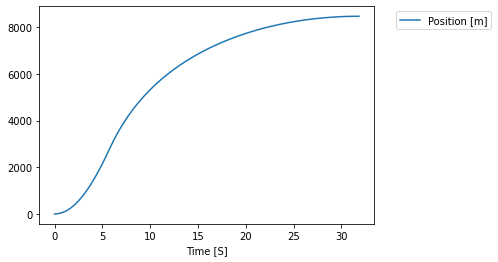

In [75]:
time = np.linspace(0,X[3], int(X[3]*100))
#plt.plot(time[:i], p[:i], label="Position [m]")
plt.plot(time[:i], v[:i], label="Velocity [m/s]")
#plt.plot(time[:i], a[:i], label="Acceleration[m/s^2]")
plt.plot(time[:i], Fnet[:i], label="Force[N]")
#plt.plot(time[:i], Fg[:i], label="Gravitational Force[N]")
plt.plot(time[:i], Fd[:i], label="Drag[M]")
#plt.plot(time[:i], Mi[:i], label="Mass [Kg]")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Time [S]")

Optimization of Height

In [76]:
def objective(X):
    '''objective function to minimize. It is the negative of profit,
    which we seek to maximize.'''
    r, h, fuel_percent,t = X
    p, v, a, Fnet, Fg, Fd, Mi, i = rocket_launch(r, h, fuel_percent, t)
    return -(max(p))

In [77]:
max_specs = [0,0,0,0]
maximum = 0

for i in range(10, 100, 4):
  print("checking " + str(i))
  X = fmin_cobyla(objective, x0=[0.2 + 0.001*i, 2.0+0.01*i, 0.5, i], cons=[c1, c2, c3, c4, c5, c6, c7])
  if(-objective(X) > maximum):
    max_specs = X
    maximum = -objective(X)

checking 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in double_scalars


checking 14
checking 18
checking 22
checking 26
checking 30
checking 34
checking 38
checking 42
checking 46
checking 50
checking 54
checking 58
checking 62
checking 66
checking 70
checking 74
checking 78
checking 82
checking 86
checking 90
checking 94
checking 98


In [78]:
p, v, a, Fnet, Fg, Fd, Mi, i = rocket_launch(max_specs[0], max_specs[1], max_specs[2], max_specs[3])
vels = list(v)
max_value = max(vels)
max_index = vels.index(max_value)
print('Radius of {0:1.2f} m.'.format(max_specs[0]))
print('Rocket height of {0:1.2f} m'.format(max_specs[1]))
print('Fuel Tank Percent {0:1.2f}% '.format(max_specs[2]*100))
print('Burn Time:  {0:4f} s '.format(max_index / 100))
print('Max Height:  {0:1.2f} m '.format(p[i]))
print('Starting Weight:  {0:1.2f} N '.format(Fg[0]))
print("Fuel tank thickness : {0:1.4f} mm".format(tank_specs(max_specs[0], max_specs[1])[2]*1000))
print("Fuel tank volume : {0:1.3f} m^3".format(tank_specs(max_specs[0], max_specs[1])[0]))
print("Quantity of Fuel : {0:1.3f} m^3".format(tank_specs(max_specs[0], max_specs[1])[0]*max_specs[2]))
print('Max Velocity Attained {0:1.2f} m/s.'.format(max(v)))
print('Avg Velocity Attained {0:1.2f} m/s.'.format(np.mean(v)))

Radius of 0.21 m.
Rocket height of 4.01 m
Fuel Tank Percent 99.40% 
Burn Time:  69.500000 s 
Max Height:  22244.54 m 
Starting Weight:  3330.15 N 
Fuel tank thickness : 0.5251 mm
Fuel tank volume : 0.280 m^3
Quantity of Fuel : 0.278 m^3
Max Velocity Attained 382.51 m/s.
Avg Velocity Attained 285.75 m/s.


Text(0.5, 0, 'Time [S]')

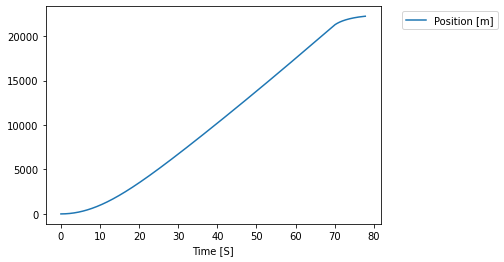

In [79]:
time = np.linspace(0,X[3], int(X[3]*100))
#plt.plot(time[:i], p[:i], label="Position [m]")
plt.plot(time[:i], v[:i], label="Velocity [m/s]")
#plt.plot(time[:i], a[:i], label="Acceleration[m/s^2]")
plt.plot(time[:i], Fnet[:i], label="Force[N]")
#plt.plot(time[:i], Fg[:i], label="Gravitational Force[N]")
plt.plot(time[:i], Fd[:i], label="Drag[M]")
#plt.plot(time[:i], Mi[:i], label="Mass [Kg]")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Time [S]")


Optimization of Average Velocity

In [80]:
def objective(X):
    '''objective function to minimize. It is the negative of profit,
    which we seek to maximize.'''
    r, h, fuel_percent,t = X
    p, v, a, Fnet, Fg, Fd, Mi, i = rocket_launch(r, h, fuel_percent, t)
    return -(np.mean(v))

In [81]:
max_specs = [0,0,0,0]
maximum = 0

for i in range(10, 100, 4):
  print("checking " + str(i))
  X = fmin_cobyla(objective, x0=[0.2 + 0.001*i, 2.0+0.01*i, 0.5, i], cons=[c1, c2, c3, c4, c5, c6, c7])
  if(-objective(X) > maximum):
    max_specs = X
    maximum = -objective(X)

checking 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in double_scalars


checking 14
checking 18
checking 22
checking 26
checking 30
checking 34
checking 38
checking 42
checking 46
checking 50
checking 54
checking 58
checking 62
checking 66
checking 70
checking 74
checking 78
checking 82
checking 86
checking 90
checking 94
checking 98


In [82]:
p, v, a, Fnet, Fg, Fd, Mi, i = rocket_launch(max_specs[0], max_specs[1], max_specs[2], max_specs[3])
vels = list(v)
max_value = max(vels)
max_index = vels.index(max_value)
print('Radius of {0:1.2f} m.'.format(max_specs[0]))
print('Rocket height of {0:1.2f} m'.format(max_specs[1]))
print('Fuel Tank Percent {0:1.2f}% '.format(max_specs[2]*100))
print('Burn Time:  {0:4f} s '.format(max_index / 100))
print('Max Height:  {0:1.2f} m '.format(p[i]))
print('Starting Weight:  {0:1.2f} N '.format(Fg[0]))
print("Fuel tank thickness : {0:1.4f} mm".format(tank_specs(max_specs[0], max_specs[1])[2]*1000))
print("Fuel tank volume : {0:1.3f} m^3".format(tank_specs(max_specs[0], max_specs[1])[0]))
print("Quantity of Fuel : {0:1.3f} m^3".format(tank_specs(max_specs[0], max_specs[1])[0]*max_specs[2]))
print('Max Velocity Attained {0:1.2f} m/s.'.format(max(v)))
print('Avg Velocity Attained {0:1.2f} m/s.'.format(np.mean(v)))

Radius of 0.11 m.
Rocket height of 2.16 m
Fuel Tank Percent 78.97% 
Burn Time:  8.600000 s 
Max Height:  5192.50 m 
Starting Weight:  673.69 N 
Fuel tank thickness : 0.2825 mm
Fuel tank volume : 0.044 m^3
Quantity of Fuel : 0.034 m^3
Max Velocity Attained 705.88 m/s.
Avg Velocity Attained 468.60 m/s.


Text(0.5, 0, 'Time [S]')

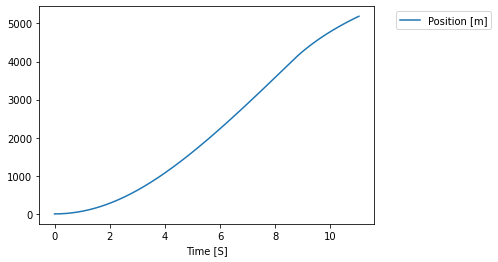

In [83]:
time = np.linspace(0,X[3], int(X[3]*100))
#plt.plot(time[:i], p[:i], label="Position [m]")
plt.plot(time[:i], v[:i], label="Velocity [m/s]")
#plt.plot(time[:i], a[:i], label="Acceleration[m/s^2]")
plt.plot(time[:i], Fnet[:i], label="Force[N]")
#plt.plot(time[:i], Fg[:i], label="Gravitational Force[N]")
plt.plot(time[:i], Fd[:i], label="Drag[M]")
#plt.plot(time[:i], Mi[:i], label="Mass [Kg]")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Time [S]")